In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import abc
import numbers
import logging
import pandas as pd
from scipy import sparse
from scipy.sparse.linalg import norm
import pandas as pd
import random

import matplotlib.pyplot as plt
import time
from sklearn import preprocessing
from numpy import linalg as LA
import scipy

np.random.seed(41)

# Spectrahedron

https://github.com/lawrencelan97/sgd/blob/master/Matrix%20Completion%20Using%20Stochastic%20Gradient%20Descent.ipynb

https://zib-iol.github.io/FrankWolfe.jl/dev/examples/docs_3_matrix_completion/#Matrix-Completion

https://arxiv.org/pdf/2104.06675.pdf

https://github.com/ZIB-IOL/FrankWolfe.jl/blob/master/src/afw.jl#L484

In [ ]:
# produce vectors of users, movies, ratings (given values)
dataset = pd.read_csv('data/ratings.csv').drop('timestamp', axis=1)
users = dataset['userId'].values
movies = dataset['movieId'].values
ratings = dataset['rating'].values
obs = [(users[i]-1, movies[i]-1) for i in range(len(users))] # form tuples
# form sparse matrix
M = sparse.coo_matrix((ratings, (users-1,movies-1))).tocsr()
obs = [(users[i]-1, movies[i]-1) for i in range(len(users))] # form tuples
max(obs)

(609, 170874)

In [ ]:

def csr_matrix_indices_gen(S):
    """
    Generate the indices of nonzero entries of a csr_matrix S
    """
    major_dim, minor_dim = S.shape
    minor_indices = S.indices
    
    for i in range(major_dim):
        for j in range(S.indptr[i], S.indptr[i+1]):
            major_index, minor_index = i, minor_indices[j]
            yield major_index, minor_index

In [ ]:
n_dim = 1500

In [ ]:
K = np.zeros(shape=(n_dim, n_dim))
indices = []
missing_rate = 0.05
missing_rating = []
present_rating = []
for (i, j) in csr_matrix_indices_gen(M):
    if i < n_dim and j < n_dim:
        if np.random.rand() < missing_rate:
            K[i, j] = M[i, j]
            missing_rating.append((i, j))
        else:
            present_rating.append((i, j))
            K[i, j] = M[i, j]


In [ ]:
# K = np.random.rand(n_dim, n_dim)

In [ ]:
s  = scipy.sparse.linalg.svds(K, k=2)[1]
norm_estimation = 100 * s[1]

In [ ]:

def f(X):
    r = 0.0
    for (i, j) in present_rating:
        r += 0.5 * (X[i, j] - K[i, j])**2
    return r 


def grad_f(X):
    storage = np.zeros_like(X)
    for (i, j) in present_rating:
        storage[i, j] = X[i, j] - K[i, j]
    return storage 

def test_loss(X):
    r = 0.0
    for (i, j) in missing_rating:
        r += 0.5 * (X[i, j] - K[i, j])**2
    return r 


def sparse_dot_product(a, b):
    r = 0
    for (i, j) in present_rating:
        r += a[i, j] * b[i, j]
    return r

def spectrahedron_extreme_point(grad):
    gradient_container = grad
    gradient_container = np.multiply(-1.0,  gradient_container)
    vals, evec = scipy.sparse.linalg.eigs(gradient_container, k=1, which='LR')
    # type annotation because of Arpack instability
    unit_vec = evec[:, 0].real
    unit_vec = np.sqrt(norm_estimation) * unit_vec
    s = unit_vec[:, np.newaxis] * unit_vec
    id_m = None
    return id_m, s


# Local FW on probability simplex
def LMO_local(grad_x, s_list):
    tr = []
    grd = grad_x
    for s in s_list:
        s_m = s
        tr.append(sparse_dot_product(grd, s_m))
    ret_id = np.argmin(tr)
    ret_s = s_list[ret_id]
    return ret_id, ret_s

# Away on probability simplex
def away_step(grad_x, s_list):
    tr = []
    grd = grad_x
    for s in s_list:
        s_m = s
        tr.append(sparse_dot_product(grd, s_m))
    ret_id = np.argmax(tr)
    ret_s = s_list[ret_id]
    return ret_id, ret_s

In [ ]:
direction = np.ones(shape=(n_dim, n_dim))
_, x_0 = spectrahedron_extreme_point(direction)

In [ ]:
x_start = x_0

In [ ]:
num_of_pairs = 10
L_estimate = -100

for i in range(num_of_pairs):
    u1 = np.random.rand(x_0.shape[0])
    u1 = u1 / np.sum(u1)
    u1 =  u1 * norm_estimation
    v1 = np.random.rand(x_0.shape[1])
    v1 = v1 / np.sum(v1)
    x = u1[:, np.newaxis] * v1
    u2 = np.random.rand(x_0.shape[0])
    u2 = u2 / np.sum(u2)
    u2 = u2 * norm_estimation
    v2 = np.random.rand(x_0.shape[1])
    v2 = v2 / np.sum(v2)
    y = u2[:, np.newaxis] * v2
    gradient = grad_f(x)
    gradient_aux = grad_f(y)
    new_L = np.linalg.norm(gradient - gradient_aux) / np.linalg.norm(x - y)
    if new_L > L_estimate:
        L_estimate = new_L

print(L_estimate)

0.12215873192327042


In [ ]:

# step size funtion http://proceedings.mlr.press/v108/pedregosa20a/pedregosa20a.pdf

def take_step_size(f, d_t, x_t, g_t, L, gama_max):

    # power factor
    tau = 1.5

    mu = 0.9

    # Lipschitz estimate
    M = 1 * L * (1 + mu)

    n_dt = np.linalg.norm(d_t, 2) ** 2

    # Estimate step size
    gama = min((g_t / (M * n_dt)), gama_max)

    # quadratic approximation
    Q_t = f(x_t) - gama * g_t + 0.5 * M * n_dt * gama**2

    f_new = f(x_t - gama * d_t)

    while f_new > Q_t:

        M = tau * M

        # update step size
        gama = min((g_t / (M * n_dt)), gama_max)

        # update quadratic term
        Q_t = f(x_t) - gama * g_t + 0.5 * M * n_dt * gama**2

        f_new = f(x_t - gama * d_t)

    return gama, M

In [ ]:
x_start

array([[ 5.12919393e-01,  3.44786060e-01,  6.40293419e-02, ...,
        -4.77179256e+01, -4.79131790e+01,  6.25839081e-01],
       [ 3.44786060e-01,  2.31766295e-01,  4.30407289e-02, ...,
        -3.20761426e+01, -3.22073925e+01,  4.20691036e-01],
       [ 6.40293419e-02,  4.30407289e-02,  7.99298425e-03, ...,
        -5.95677882e+00, -5.98115292e+00,  7.81254619e-02],
       ...,
       [-4.77179256e+01, -3.20761426e+01, -5.95677882e+00, ...,
         4.43929486e+03,  4.45745968e+03, -5.82230719e+01],
       [-4.79131790e+01, -3.22073925e+01, -5.98115292e+00, ...,
         4.45745968e+03,  4.47569882e+03, -5.84613105e+01],
       [ 6.25839081e-01,  4.20691036e-01,  7.81254619e-02, ...,
        -5.82230719e+01, -5.84613105e+01,  7.63618144e-01]])

In [ ]:
class Glob:

    def __init__(self, size=None, x_init=None):
        self.s_list = [x_init]  # construct initial s_list
        self.alpha = np.ones(1, dtype=float)

    def get_x(self):
        ret = np.dot(np.transpose(self.s_list), self.alpha)
        return ret

    def fwStep_update_alpha_S(self, step_size, index_s, s):
        if step_size == 1.0:
            self.s_list = [s]  # set the s list to be this atom only
            self.alpha = np.array([step_size])  # the weight for this atom is 1
        else:
            self.alpha = (1.0 - step_size) * self.alpha  # update weight for all the atoms originally in the s_list
            if index_s is None:  # s is new
                self.s_list.append(s)
                self.alpha = np.append(self.alpha, step_size)
            else:  # old atom
                self.alpha[index_s] += step_size

    def find_index_s(self, s):
        for i in range(len(self.s_list)):
            if np.all(self.s_list[i] == s):
                return i
        return None


In [ ]:
def BPCG_Lazy(f, grad_f, x_0):

    d_0 = np.zeros(shape=(n_dim, n_dim))

    _, x_t = spectrahedron_extreme_point(d_0)

    glob = Glob(n_dim, x_t)

    fvalues = {}
    gap_values = {}
    res = {}

    number_drop = 0 # counting drop steps (max stepsize for away step)

    # Counter: 
    it = 0

    grad = grad_f(x_t)

    _, v_0 = spectrahedron_extreme_point(grad)

    fi_t = (sparse_dot_product(grad, x_t) - sparse_dot_product(grad, v_0)) / 2
    # accuracy

    J = 1.5

    # initial Lipschitz estimate
    L = L_estimate

    tst_loss = []

    eps = 1e-7
   
    while it <= 10:
          
        primal = f(x_t)

        fvalues[it-1] = primal

        grad = grad_f(x_t)

        # Local FW
        id_FW, s_FW  =  LMO_local(grad, glob.s_list) 

        # Away vertex
        id_A, a_W   = away_step(grad, glob.s_list)

        d_t = a_W - s_FW

        d = glob.alpha[id_A]

        away_gap = sparse_dot_product(d_t, grad)

        if away_gap >= fi_t and it > 1:

            # Duality gap is not changed
            gap_values[it-1] = gap_values[it-2]

            # Take step size
            step, _ = take_step_size(f=f, d_t=d_t, x_t=x_t, g_t=away_gap, L=L, gama_max=d)

            if step - d >= eps:

                glob.alpha[id_FW] = glob.alpha[id_FW] + glob.alpha[id_A]
                
                glob.s_list.pop(id_A)

                glob.alpha = np.delete(glob.alpha, id_A)

                number_drop = number_drop + 1

                print("Drop step")

            else:
            
                glob.alpha[id_A] = glob.alpha[id_A] - step
                glob.alpha[id_FW] = glob.alpha[id_FW] + step

                # if glob.alpha[id_A] <= eps:

                #     glob.alpha[id_FW] = glob.alpha[id_FW] + glob.alpha[id_A]
                #     glob.s_list.pop(id_A)
                #     glob.alpha = np.delete(glob.alpha, id_A)

        else:

            id_W, w_FW  = spectrahedron_extreme_point(grad) 

            d_t = x_t - w_FW
            
            # Update duality gap
            gap = sparse_dot_product(d_t, grad)

            gap_values[it-1] = gap

            if gap >= fi_t / J:

                step, _ = take_step_size(f=f, d_t=d_t, x_t=x_t, g_t=gap, L=L, gama_max=1)

                glob.fwStep_update_alpha_S(step, None, w_FW)

            else:

                fi_t = fi_t / 2

        # Update active 
        x_t = glob.get_x()
        it = it + 1
        loss = test_loss(x_t)
        print("it {} primal {} dual {} test loss {}".format(it, primal, gap, loss))
        tst_loss.append(loss)


    res["primal"] = fvalues
    res["gap"] = gap_values
    res["number_drop"] = number_drop
    res["test_loss"] = tst_loss
    res["x_t"] = x_t

    return x_t, primal, res

https://www.shivajicollege.ac.in/sPanel/uploads/econtent/33dfc039a8d88fa01d763d5abcd1df20.pdf

https://math.berkeley.edu/~bernd/coimbra1.pdf

In [ ]:
[x_t, f_t, resLBPCG] = BPCG_Lazy(f, grad_f, x_start)

it 1 primal 9866147.63432257 dual 25014788.931590114 test loss 495940.3548938777
it 2 primal 8422667.999162076 dual 18147911.640069865 test loss 433400.54527480673
it 3 primal 7220193.941502465 dual 18147911.640069865 test loss 393307.6117193118
it 4 primal 6446519.669652083 dual 18147911.640069865 test loss 363289.8497945401
it 5 primal 5889968.334288542 dual 16308673.663644651 test loss 335160.6193968757
it 6 primal 5360572.915818824 dual 10403964.414963052 test loss 292928.6674875908
it 7 primal 4670770.755861498 dual 9030839.393893389 test loss 256305.96726440138
it 8 primal 4071698.9496968715 dual 7830176.277989471 test loss 256305.96726440138
it 9 primal 4071698.9496968715 dual 7830176.277989471 test loss 232624.87957684454
it 10 primal 3661988.7916038935 dual 7830176.277989471 test loss 211792.52208697452
it 11 primal 3304048.9084442975 dual 7830176.277989471 test loss 193458.3110593453
it 12 primal 2991337.696809444 dual 7830176.277989471 test loss 177315.34949330313
it 13 prim

In [ ]:
primal_LBPCG = [v for k,v in resLBPCG["primal"].items()]
gaps_LBPCG = [v for k,v in resLBPCG["gap"].items()]
loss =  resLBPCG["test_loss"]

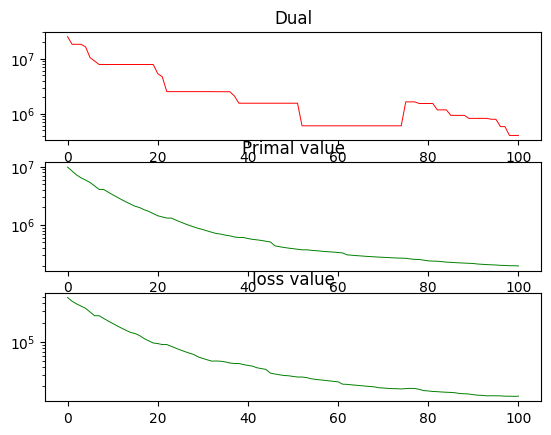

In [ ]:
figure, axis = plt.subplots(3, 1) 

axis[0].set_yscale('log')
axis[1].set_yscale('log')
axis[2].set_yscale('log')

# axis[0].set_xscale('log')
# axis[1].set_xscale('log')
# axis[2].set_xscale('log')

axis[0].semilogy([i for i in range(len(gaps_LBPCG))], gaps_LBPCG, color='r', linewidth=0.7, label ='AFW' )  
axis[0].set_title("Dual")
  
axis[1].semilogy([i for i in range(len(primal_LBPCG))], primal_LBPCG, color='g', linewidth=0.7, label ='AFW' ) 
axis[1].set_title("Primal value")

axis[2].semilogy([i for i in range(len(loss))], loss, color='g', linewidth=0.7, label ='AFW' ) 
axis[2].set_title("loss value")
 
 
plt.show()

In [ ]:
x_t

array([[7.70456114e+00, 1.04328421e+00, 1.84344854e-01, ...,
        1.69205265e+00, 5.12398546e-01, 5.34061933e-02],
       [1.04328421e+00, 1.73852363e+00, 1.25370005e-01, ...,
        2.06153070e+00, 6.24286328e-01, 6.50680151e-02],
       [1.84344854e-01, 1.25370005e-01, 1.17192851e-02, ...,
        1.67448390e-01, 5.07078263e-02, 5.28516716e-03],
       ...,
       [1.69205265e+00, 2.06153070e+00, 1.67448390e-01, ...,
        3.07949878e+00, 9.32554139e-01, 9.71981028e-02],
       [5.12398546e-01, 6.24286328e-01, 5.07078263e-02, ...,
        9.32554139e-01, 2.82402197e-01, 2.94341708e-02],
       [5.34061933e-02, 6.50680151e-02, 5.28516716e-03, ...,
        9.71981028e-02, 2.94341708e-02, 3.06786002e-03]])

In [ ]:
K

array([[4., 0., 4., ..., 0., 0., 4.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
x_t.shape

(1500, 1500)

http://math.caltech.edu/Simon_Chp8.pdf

https://www.cse.iitb.ac.in/~cs435/scribe/lecture10s.pdf

https://www.cse.iitb.ac.in/~cs435/scribe/lecture10s.pdf

https://ocw.mit.edu/courses/6-241j-dynamic-systems-and-control-spring-2011/04fddfbcb1eb933ecca85dab8bfbb171_MIT6_241JS11_chap04.pdf

https://andrewcharlesjones.github.io/journal/matern-kernels.html

SVM

http://proceedings.mlr.press/v38/meshi15.pdf

https://github.com/efrandi/FW-SVMs

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f2e52909-b1a4-4725-9ec9-263af9c79dca' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>